In [21]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [2]:
root = "/kaggle/input/wider-data/WIDER/"

def read_annots(file, max_faces=20):
    def get_coords(line):
        coor = line.split(" ")
        xywh = [int(coor[i]) for i in range(4)] if(len(coor) > 4) else None
        return xywh
    
    data = []
    
    with open(file, "r") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if ".jpg" in line:
                annot = {
                    "path": line.strip(),
                    "box_num": int(lines[i+1]),
                    "boxes": [],
                    "label": [],
                }
                if max_faces >= annot["box_num"]:
                    for j in range(annot["box_num"]):
                        box = get_coords(lines[i+2+j].replace("\n", ""))
                        if box is not None:
                            x,y,w,h = box
                            
                            # xmin, ymin, xmax, ymax
                            box = [x, y, x+w, y+h]
                            annot["boxes"].append(box)
                            annot["label"].append(0)  # 1
                    if len(annot["boxes"]) > 0:
                        data.append(annot)
    return data

In [15]:
test = read_annots("/kaggle/input/wider-data/WIDER/wider_face_val_bbx_gt.txt")

In [16]:
data = pd.DataFrame.from_records(test, columns=list(test[0].keys())).explode("boxes").reset_index(drop=True)
train_points = pd.DataFrame(data["boxes"].values.tolist(), columns=["xmin", "ymin", "xmax", "ymax"], index=data.index)
data = pd.concat([data, train_points], axis=1)
data = data[~((data.xmin == data.xmax) | (data.ymin == data.ymax))]
data["class_id"] = 0
image_ids = {p: i for i, p in enumerate(data["path"].unique())}
data["image_id"] = data["path"].map(image_ids)

data.head()

path  box_num                 boxes  \
0  0--Parade/0_Parade_Parade_0_194.jpg        5  [111, 425, 233, 552]   
1  0--Parade/0_Parade_Parade_0_194.jpg        5  [209, 347, 279, 450]   
2  0--Parade/0_Parade_Parade_0_194.jpg        5  [368, 252, 457, 385]   
3  0--Parade/0_Parade_Parade_0_194.jpg        5  [555, 282, 644, 382]   
4  0--Parade/0_Parade_Parade_0_194.jpg        5  [707, 252, 799, 385]   

             label  xmin  ymin  xmax  ymax  class_id  image_id  
0  [0, 0, 0, 0, 0]   111   425   233   552         0         0  
1  [0, 0, 0, 0, 0]   209   347   279   450         0         0  
2  [0, 0, 0, 0, 0]   368   252   457   385         0         0  
3  [0, 0, 0, 0, 0]   555   282   644   382         0         0  
4  [0, 0, 0, 0, 0]   707   252   799   385         0         0

In [7]:
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

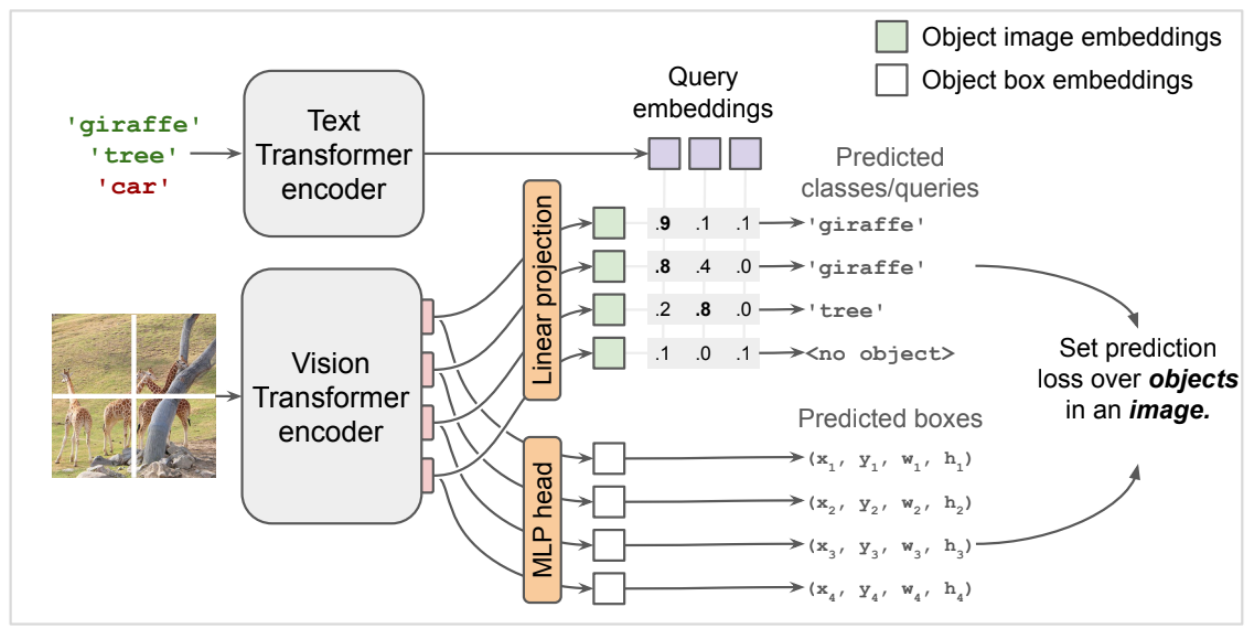

OWL-ViT uses CLIP with a ViT-like Transformer as its backbone to get multi-modal visual and text features. To use CLIP for object detection, OWL-ViT removes the final token pooling layer of the vision model and attaches a lightweight classification and box head to each transformer output token. Open-vocabulary classification is enabled by replacing the fixed classification layer weights with the class-name embeddings obtained from the text model. The authors first train CLIP from scratch and fine-tune it end-to-end with the classification and box heads on standard detection datasets using a bipartite matching loss. One or multiple text queries per image can be used to perform zero-shot text-conditioned object detection.

In [35]:
def show_box(image=None, threshold=0.1, texts=None):
    if image is None:
        idx = np.random.randint(len(data))
        image = Image.open("/kaggle/input/wider-data/WIDER/WIDER_val/" + data["path"].iloc[idx]).convert("RGB")
    if texts is None: 
        texts = [["a picture of human face"]]
    
    inputs = processor(text=texts, images=image, return_tensors="pt")
    outputs = model(**inputs)
    target_sizes = torch.Tensor([image.size[::-1]])
    results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

    text = texts[0]
    boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]
    boxes, scores, labels = boxes[scores > threshold], scores[scores > threshold], labels[scores > threshold]
    
    draw = ImageDraw.Draw(image)
    
    for box, label in zip(boxes, labels):
        draw.rectangle(xy=[tuple(box.tolist())[:2], tuple(box.tolist())[2:]])
        xmin, ymin = tuple(box.tolist())[:2]
        draw.text(xy=[xmin, ymin], text="face")

    return image

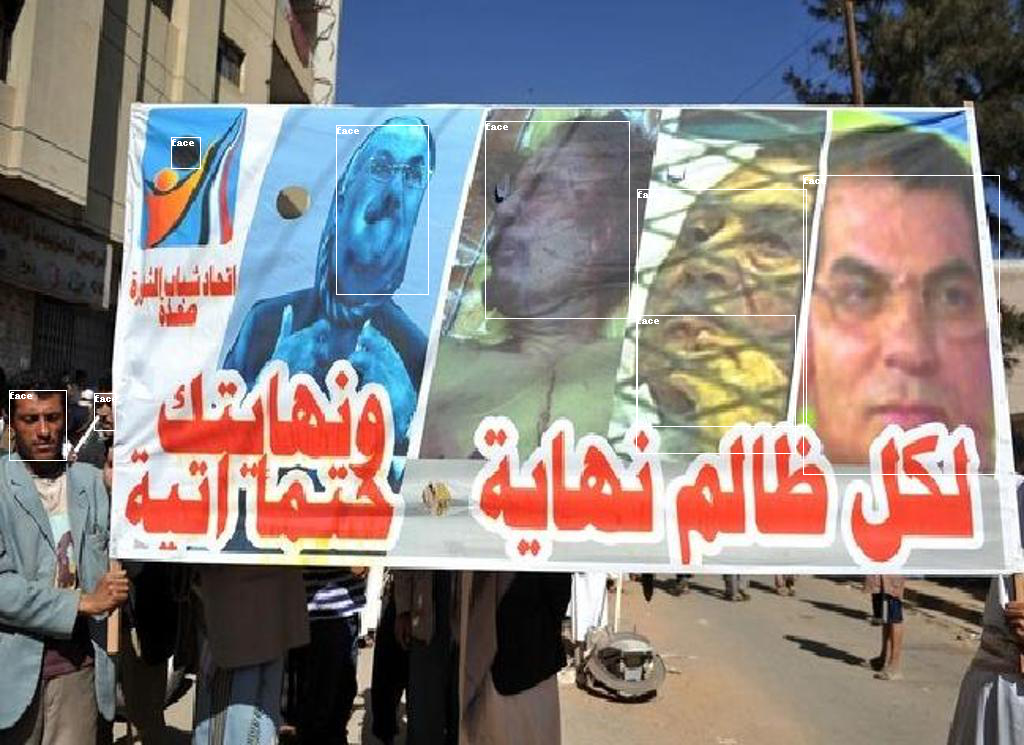

In [36]:
show_box()

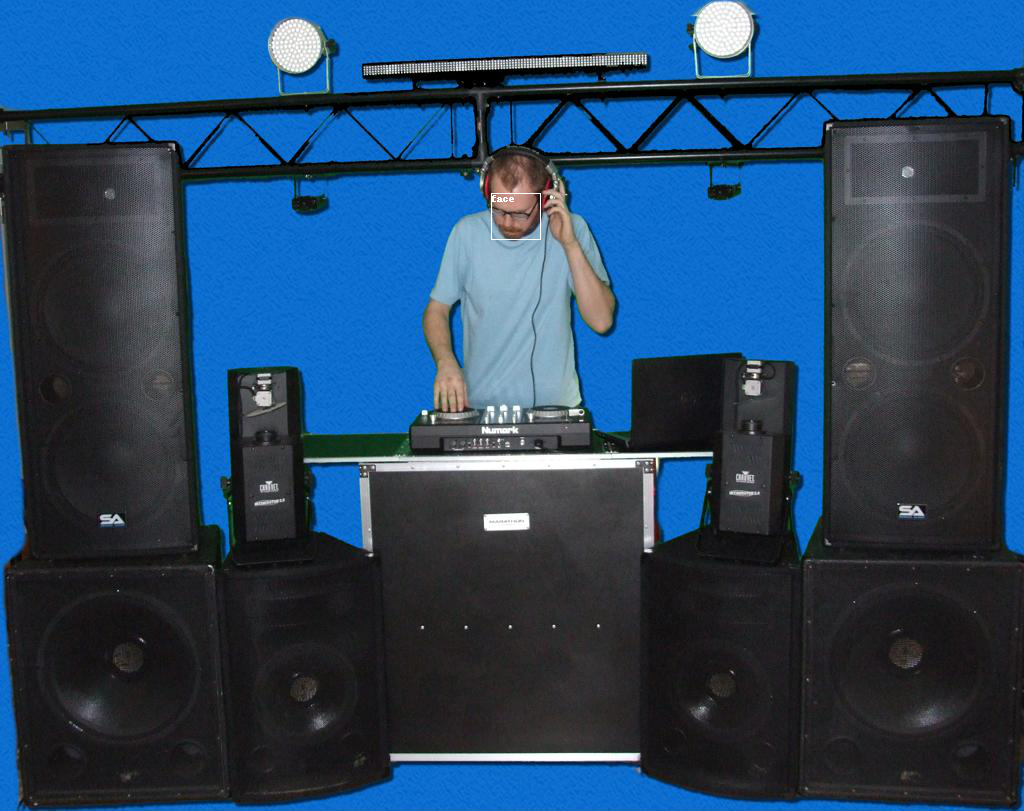

In [37]:
show_box()

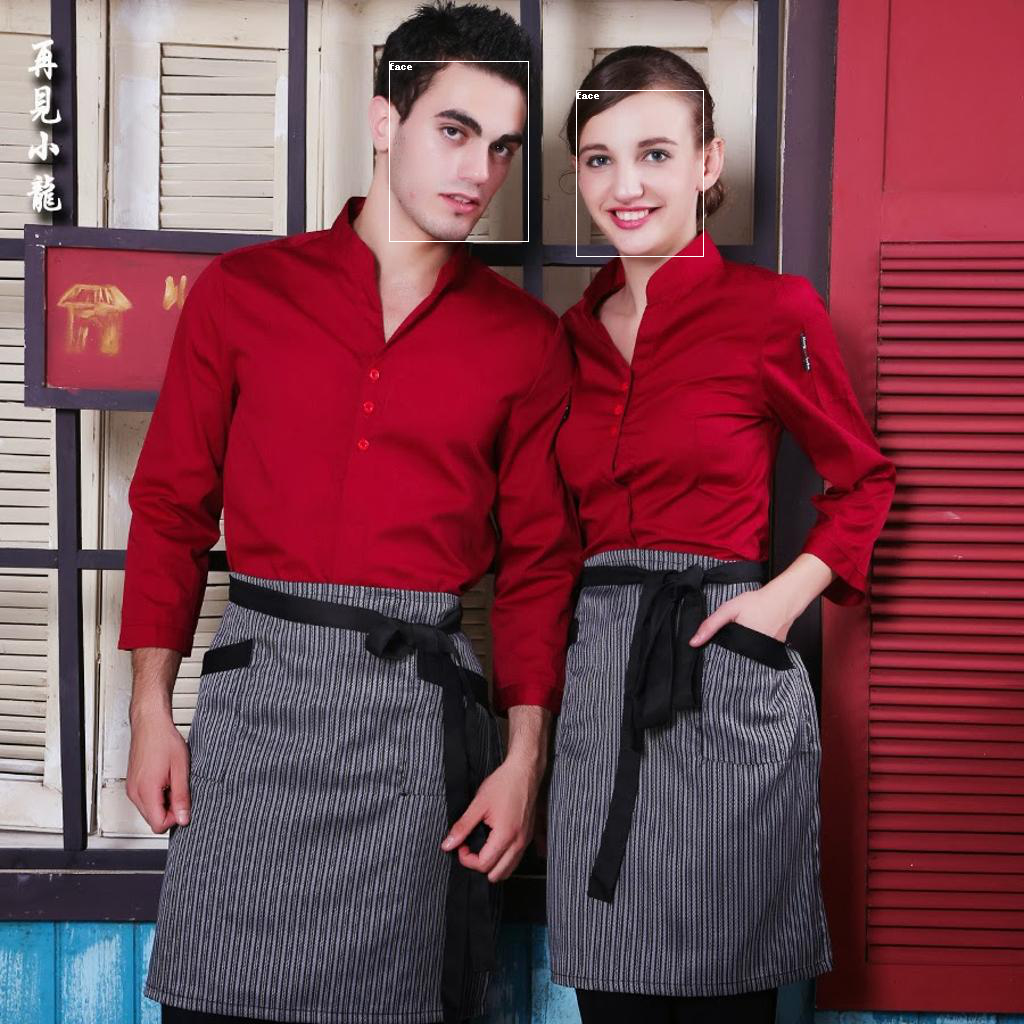

In [39]:
show_box()

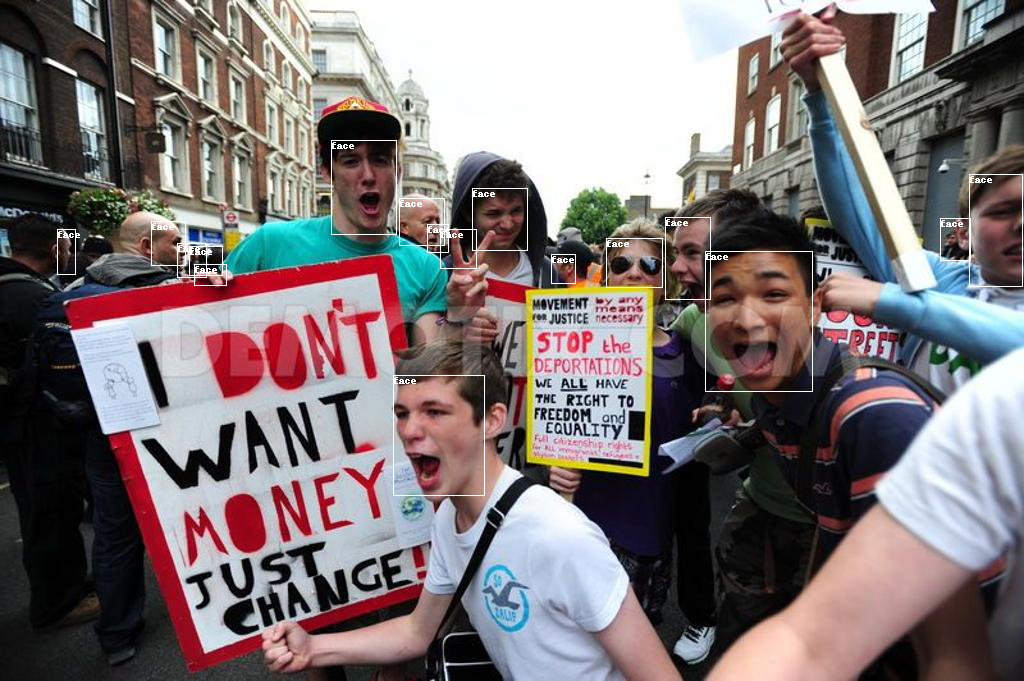

In [41]:
show_box()